<a href="https://colab.research.google.com/github/TANZID36/Cat-and-Dog-Classifier/blob/main/Dog_vs_Cat_Classifier_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting Dataset using Kaggle API

In [49]:
#installing the kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing the Dog vs Cat Dataset from kaggle

In [ ]:
#kaggle api 
!kaggle competitions download -c dogs-vs-cats

 99% 801M/812M [00:24<00:00, 33.4MB/s]
100% 812M/812M [00:25<00:00, 34.0MB/s]


In [ ]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [ ]:
#extracting the compressed dataset
from zipfile import ZipFile

dataset = '/content/dogs-vs-cats.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The Dataset is Extracted')

The Dataset is Extracted


In [ ]:
#extracting the compressed train zip file
from zipfile import ZipFile

dataset = '/content/train.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The Train Dataset file is Extracted')

The Train Dataset file is Extracted


In [ ]:
import os
#counting the number of files in train folder
path,dirs,files = next(os.walk('/content/train'))
file_count = len(files)
print('Number of images in the train directory : ', file_count)

Number of images in the train directory :  25000


Printing the name of images

In [ ]:
file_names = os.listdir('/content/train')
#print(file_names)

Importing the Dependencies

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Displaying the images of dogs and cats

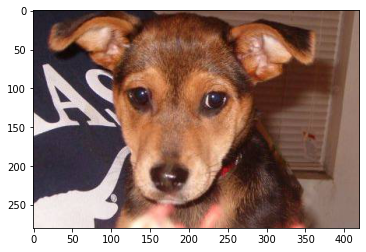

In [ ]:
#displaying dog image
img = mpimg.imread('/content/train/dog.10289.jpg')
imgplot = plt.imshow(img)
plt.show()

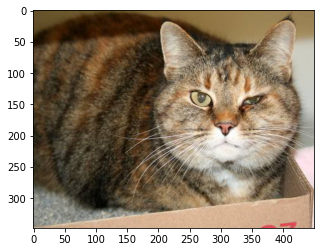

In [ ]:
#displaying cat image
img = mpimg.imread('/content/train/cat.12179.jpg')
imgplot = plt.imshow(img)
plt.show()

Counting number of dog and cat images

In [ ]:
file_names = os.listdir('/content/train/')

dog_count = 0
cat_count = 0

for img_file in file_names:
  name = img_file[0:3]
  if name == 'dog':
    dog_count +=1
  else:
    cat_count+=1

print('Number of dog images : ',dog_count)
print('Number of cat images : ',cat_count)

Number of dog images :  12500
Number of cat images :  12500


Resizing all the images since mobilenetv2 model requires specific size of images

In [ ]:
#creating a directory for the resized images
os.mkdir('/content/image resized')

In [ ]:
original_folder = '/content/train/'
resized_folder = '/content/image resized/'

#in this for loop we are giving the varible img_path the names of the files from the original folder
#now the img_path contains the name of the files from original folder
#we are only taking 2000 images to train the pretrained model
for i in range(2000):
  filename = os.listdir(original_folder)[i]
  img_path = original_folder+filename

  img = Image.open(img_path)
  img = img.resize((224,224))
  img = img.convert('RGB')

  newImgPath = resized_folder+filename
  img.save(newImgPath)

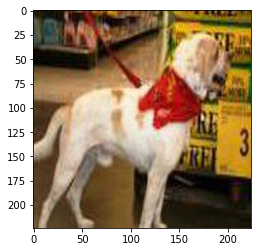

In [ ]:
#displaying the resized image
img = mpimg.imread('/content/image resized/dog.1012.jpg')
imgplt = plt.imshow(img)
plt.show()

Creating the label for resized images of dogs and cats

Cat == 0, Dog == 1

In [ ]:
#creating a loop to assign labels
filenames = os.listdir('/content/image resized/')
labels=[]

for i in range(2000):
  file_name = filenames[i]
  label = file_name[0:3]

  if label == 'dog':
    labels.append(1)
  else:
    labels.append(0)

In [ ]:
print(len(filenames))

2000


In [ ]:
print(len(labels))

2000


In [ ]:
#counting the iamges of dogs and cats out of 2000 resized images
values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

[0 1]
[1001  999]


Converting all the resized images of numpy arrays

In [ ]:
import cv2
import glob

In [ ]:
image_directory = '/content/image resized/'
image_extension = ['png','jpg']

files = []

#interating the files to check for the image with correct extension
[files.extend(glob.glob(image_directory + '*.' + e)) for e in image_extension]
dog_cat_images = np.asarray([cv2.imread(file) for file in files])

In [ ]:
print(dog_cat_images.shape)

(2000, 224, 224, 3)


In [ ]:
X = dog_cat_images
Y = np.asarray(labels)

Train Test Split

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2, random_state=2)

In [ ]:
print(X.shape,X_train.shape,X_test.shape)

(2000, 224, 224, 3) (1600, 224, 224, 3) (400, 224, 224, 3)


In [ ]:
#scaling the data since the pixel size number are high, from 0 to 224
X_train_scaled = X_train/255
X_test_scaled = X_test/255

Building the Neural Network

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model = hub.KerasLayer(mobilenet_model,input_shape=(224,224,3), trainable=False)

In [ ]:
num_of_classes = 2

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile( 
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['acc']
)

In [ ]:
model.fit(X_train_scaled,Y_train, epochs=5)

Epoch 1/5
50/50 [==============================] - 47s 844ms/step - loss: 0.2398 - acc: 0.8981
Epoch 2/5
50/50 [==============================] - 43s 863ms/step - loss: 0.0721 - acc: 0.9756
Epoch 3/5
50/50 [==============================] - 41s 829ms/step - loss: 0.0508 - acc: 0.9837
Epoch 4/5
50/50 [==============================] - 42s 831ms/step - loss: 0.0430 - acc: 0.9862
Epoch 5/5
50/50 [==============================] - 40s 805ms/step - loss: 0.0358 - acc: 0.9894


In [ ]:
model.save('cat_dog_model.h5')

In [ ]:
score, acc = model.evaluate(X_test_scaled, Y_test)
print('Test Loss = ', score)
print('Test accuracy = ',acc)

13/13 [==============================] - 11s 783ms/step - loss: 0.0746 - acc: 0.9775
Test Loss =  0.07461719214916229
Test accuracy =  0.9775000214576721


Building a Predictive System

Path of the image to be predicted: /content/cat.jpg


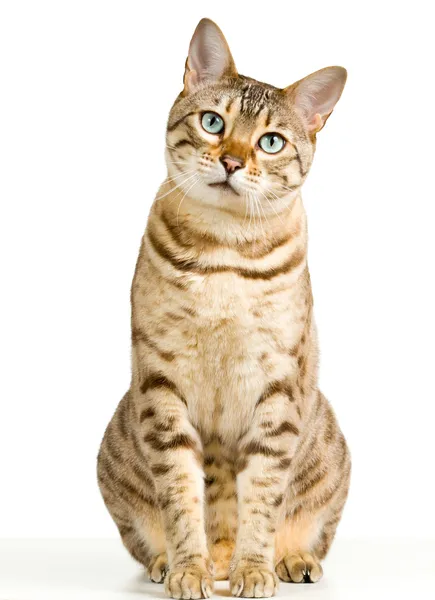

The image is of a Cat


In [ ]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)

input_image_resize = cv2.resize(input_image, (224,224))
input_image_scaled = input_image_resize/225
image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])
input_prediction = model.predict(image_reshaped)
input_pred_label = np.argmax(input_prediction)

#print(input_pred_label)

if input_pred_label == 0:
  print('The image is of a Cat')
else:
  print('The image is of a Dog')

Path of the image to be predicted: /content/dog.jpg


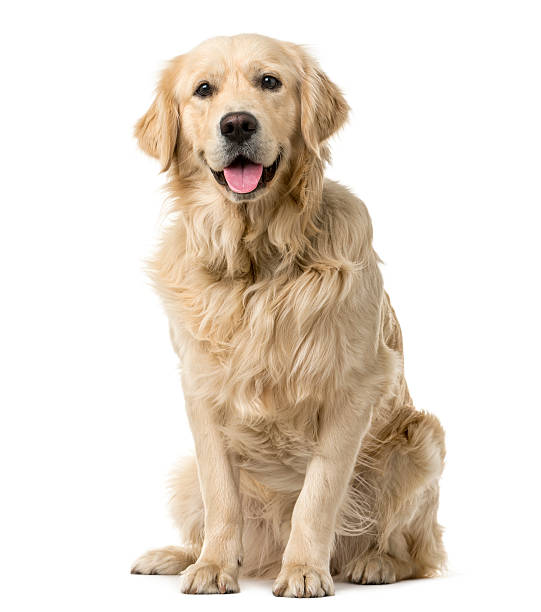

The image is of a Dog


In [ ]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)

input_image_resize = cv2.resize(input_image, (224,224))
input_image_scaled = input_image_resize/225
image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])
input_prediction = model.predict(image_reshaped)
input_pred_label = np.argmax(input_prediction)

#print(input_pred_label)

if input_pred_label == 0:
  print('The image is of a Cat')
else:
  print('The image is of a Dog')